<a href="https://colab.research.google.com/github/BuddGao/DL-Competition/blob/main/competition_compare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#COVID-19 Prediction

In [1]:
## mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
## if you haven't unzipped training data
#!unzip "drive/MyDrive/DL_Project/Train.zip" -d  "drive/MyDrive/DL_Project/"

## if you haven't unzipped val data
#!unzip "drive/MyDrive/DL_Project/Val Blind.zip" -d  "drive/MyDrive/DL_Project/"

## Custom Dataset Class

In [3]:
## preprocess data
## create custom data class

import os
import torch
import pandas as pd
from skimage import io, transform

import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import cv2
from PIL import Image
import glob

class CovidDataset(Dataset):
    """Covid CT dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.label_data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        ## you can apply custom transformation on the image for data augmentation
        self.transform = transform

    def __len__(self):
        return len(self.label_data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.label_data.iloc[idx, 0])
        image = io.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
        image = torchvision.transforms.functional.to_tensor(image)
        p = self.label_data.iloc[idx, 1]
        subject_num = self.label_data.iloc[idx, 2]
        sample = {'image': image, 'percentage': p, 'subject': subject_num, 'img_name':img_name}

        # should be only applied on image, not percentage or subject #
        if self.transform:
            sample = self.transform(sample)

        return sample

In [4]:
class CovidTestDataset(Dataset):
    """Covid CT TEST dataset."""

    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.image_list = []
        for filename in glob.glob(self.root_dir+"/*.png"): #assuming png
          self.image_list.append(filename)

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.image_list[idx]
        image = io.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
        image = torchvision.transforms.functional.to_tensor(image)
        sample = {'image': image, 'img_name':img_name}

        return sample

In [5]:
import torchvision
covid_dataset_train_val = CovidDataset(csv_file='drive/MyDrive/DL_Project/Train.csv',
                                    root_dir='drive/MyDrive/DL_Project/Train'
                                    #, transform = transforms.Compose([
                                    #           Rescale(256),
                                    #           RandomCrop(224),
                                    #           ToTensor()
                                    #       ])
                                    )

covid_dataset_test = CovidTestDataset(root_dir='drive/MyDrive/DL_Project/Val')

0 torch.Size([3, 512, 512]) 0.0 0
1 torch.Size([3, 512, 512]) 0.0 0
2 torch.Size([3, 512, 512]) 0.0 0
3 torch.Size([3, 512, 512]) 0.0 0


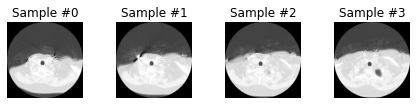

In [6]:
## plot training example
for i in range(len(covid_dataset_train_val)):
    sample = covid_dataset_train_val[i]
    print(i, sample['image'].shape, sample['percentage'], sample['subject'])
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample['image'].numpy().transpose(1,2,0))
    if i == 3:
        plt.show()
        break

0 torch.Size([3, 512, 512]) drive/MyDrive/DL_Project/Val/Image_0304.png
1 torch.Size([3, 512, 512]) drive/MyDrive/DL_Project/Val/Image_0301.png
2 torch.Size([3, 512, 512]) drive/MyDrive/DL_Project/Val/Image_0302.png
3 torch.Size([3, 512, 512]) drive/MyDrive/DL_Project/Val/Image_0303.png


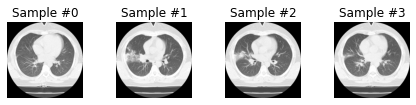

In [7]:
## plot test examples
for i in range(len(covid_dataset_test)):
    sample = covid_dataset_test[i]
    print(i, sample['image'].shape, sample['img_name'])
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample['image'].numpy().transpose(1,2,0))
    if i == 3:
        plt.show()
        break

##Split given train set to train & val set

In [8]:
## split given train set to train & val set

#dataloader = DataLoader(covid_dataset, batch_size=4, shuffle=True, num_workers=0)
print(len(covid_dataset_train_val))
train_size = int(0.7 * len(covid_dataset_train_val))
val_size = len(covid_dataset_train_val) - train_size
print(train_size, val_size)
train_dataset, val_dataset = torch.utils.data.random_split(covid_dataset_train_val, [train_size, val_size])
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True, num_workers=0)

## test set
test_dataloader = DataLoader(covid_dataset_test, batch_size=8, shuffle=True, num_workers=0)

3053
2137 916


### Apply CV

In [9]:
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.model_selection import KFold

# generate the index of subjects for k-fold cross validation
def generate_index(dat,k):
    
    Y = list(range(0,dat[-1]['subject']+1))
    kf = KFold(n_splits=k, shuffle=True)

    n = len(Y)
    index = {'train_index':[],
             'val_index':[]}

    for train_index, val_index in kf.split(np.zeros(n), Y):
        index['train_index'].append(train_index)
        index['val_index'].append(val_index)
        
    
    return pd.DataFrame(index['train_index']).T,pd.DataFrame(index['val_index']).T

In [10]:
# get links form subjects to images
df = pd.read_csv('drive/MyDrive/DL_Project/Train.csv')
subtoimage = []
le = []
for sub in range(0,covid_dataset_train_val[-1]['subject']+1):
  subtoimage.append(df[df['0'] == sub].index.tolist())
  le.append(len(df[df['0'] == sub].index.tolist()))

In [11]:
# get images' index form subjects' index
def get_image_index(subindex,subtoimage):
    imageindex = []
    for sub in range(0,len(subindex)):
        imageindex.extend(subtoimage[subindex[sub]])
    return imageindex

In [45]:
# from typing import NewType
def cv_train(pars, k=4, dir='drive/MyDrive/DL_Project/CV/',n_epochs=20):
  train_index,val_index = generate_index(covid_dataset_train_val,k)
  model_cv = []
  valid_cvloss = []
  valid_cvloss_trend = []
  for split_i in range(0,k):
    print('CV - Fold ', split_i)
    fold_dir = dir + str(split_i) + '/'

    if not os.path.isdir(fold_dir):
      os.makedirs(fold_dir)
      print("created folder : ", fold_dir)
    else:
      print(fold_dir, "folder already exists.")

    model, cri, lr = pars
    freeze_stat = True
    model_CNN = model(pretrained=True,freeze=freeze_stat).to(device)
    criterion = cri
    model_CNN_grad_paramaters = filter(lambda p: p.requires_grad, model_CNN.parameters())
    optimizer = optim.Adam(model_CNN_grad_paramaters, lr=lr)

    ## split given train set to train & val set by subjects
    train_imageindex = get_image_index(train_index.iloc[:,split_i],subtoimage)
    val_imageindex = get_image_index(val_index.iloc[:,split_i],subtoimage)
    train_dataset = torch.utils.data.Subset(covid_dataset_train_val,train_imageindex)
    val_dataset = torch.utils.data.Subset(covid_dataset_train_val,val_imageindex)
    train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
    val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True, num_workers=0)

    ## training model
    model_conv, valid_loss_min, valid_loss_trend = train_model(model_CNN, criterion, optimizer,train_dataloader,val_dataloader, dir=fold_dir,n_epochs=n_epochs)

    model_cv.append(model_conv)
    valid_cvloss.append(valid_loss_min)
    valid_cvloss_trend.append(valid_loss_trend)
  
  print('----------------------Final CV loss: %.6f -----------------------' % torch.stack(valid_cvloss).cpu().data.mean() )
  
  return model_cv, valid_cvloss, valid_cvloss_trend

## Import pretrained models library

In [13]:
## use imagenet pretrained model
## let's start with resnet34
!pip install pretrainedmodels

In [14]:
# pretrainedmodels.__dict__

NameError: ignored

## Use CUDA to speed up training

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Create Baseline Model

In [16]:
import pretrainedmodels
#For model building
import torch
from torch import nn, optim
import torchvision
from torch.nn import functional as F

class CNN1(nn.Module):
    def __init__(self, pretrained=True,freeze=True):
        super(CNN1, self).__init__()
        if pretrained is True:
            self.model = pretrainedmodels.__dict__["resnet34"](pretrained="imagenet")
        else:
            self.model = pretrainedmodels.__dict__["resnet34"](pretrained=None)
        if freeze is True:
            for param in self.model.parameters():
                param.requires_grad = False
        #self.fc1 = nn.Linear(512, 256)
        self.conv1 = nn.Conv2d(512, 128, (5,5), stride=1, padding =0)
        self.conv2 = nn.Conv2d(128, 32, (5,5), stride=1, padding =0)
        self.dropout = nn.Dropout(p=0.5)
        self.conv3 = nn.Conv2d(32, 8, (5,5), stride=1, padding =0)
        self.fc1 = nn.Linear(128, 1)
        
    def forward(self, x):
        bs, _, _, _ = x.shape
        x = self.model.features(x)
        #x = F.adaptive_avg_pool2d(x) #.reshape(bs, -1)
        #x = F.relu(self.fc1(x))
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dropout(x)
        x = self.conv3(F.relu(x))
        #print(x.size()) # [8, 8, 4, 4]
        label = self.fc1(x.reshape(bs, -1))  # [8, 128]
        return label

In [17]:
class CNN2(nn.Module):
    def __init__(self, pretrained=True,freeze=True):
        super(CNN2, self).__init__()
        if pretrained is True:
            self.model = pretrainedmodels.__dict__["resnet18"](pretrained="imagenet")
        else:
            self.model = pretrainedmodels.__dict__["resnet18"](pretrained=None)
        if freeze is True:
            for param in self.model.parameters():
                param.requires_grad = False
        #self.fc1 = nn.Linear(512, 256)
        self.conv1 = nn.Conv2d(512, 128, (5,5), stride=1, padding =0)
        self.conv2 = nn.Conv2d(128, 32, (5,5), stride=1, padding =0)
        self.dropout = nn.Dropout(p=0.5)
        self.conv3 = nn.Conv2d(32, 8, (5,5), stride=1, padding =0)
        self.fc1 = nn.Linear(128, 1)
        
    def forward(self, x):
        bs, _, _, _ = x.shape
        x = self.model.features(x)
        #x = F.adaptive_avg_pool2d(x) #.reshape(bs, -1)
        #x = F.relu(self.fc1(x))
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dropout(x)
        x = self.conv3(F.relu(x))
        #print(x.size()) # [8, 8, 4, 4]
        label = self.fc1(x.reshape(bs, -1))  # [8, 128]
        return label

In [18]:
# reference: https://github.com/mr7495/COVID-CT-Code/blob/master/COVID_Train%26Validation.ipynb
class CNN3(nn.Module):
    def __init__(self, pretrained=True,freeze=True):
        super(CNN3, self).__init__()
        if pretrained is True:
            self.model = pretrainedmodels.__dict__["resnet50"](pretrained="imagenet")
        else:
            self.model = pretrainedmodels.__dict__["resnet50"](pretrained=None)
        if freeze is True:
            for param in self.model.parameters():
                param.requires_grad = False
        #self.fc1 = nn.Linear(512, 256)
        self.conv1 = nn.Conv2d(512, 128, (5,5), stride=1, padding =0)
        self.conv2 = nn.Conv2d(128, 32, (5,5), stride=1, padding =0)
        self.dropout = nn.Dropout(p=0.5)
        self.conv3 = nn.Conv2d(32, 8, (5,5), stride=1, padding =0)
        self.fc1 = nn.Linear(128, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)
        
    def forward(self, x):
        bs, _, _, _ = x.shape
        x = self.model.features(x)
        #x = F.adaptive_avg_pool2d(x) #.reshape(bs, -1)
        #x = F.relu(self.fc1(x))
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dropout(x)
        x = self.conv3(F.relu(x))
        # print(x.size()) # [8, 8, 4, 4]
        label = self.fc1(x.reshape(bs, -1))  # [8, 128]
        label = self.fc2(label)
        label = self.fc3(label)
        return label

In [46]:
# reference: https://towardsdatascience.com/using-pretrained-deep-convolutional-neural-networks-for-binary-classification-of-covid-19-ct-scans-3a7f7ea8b543
class CNN5(nn.Module):
    def __init__(self, pretrained=True, freeze=True):
        super(CNN5, self).__init__()
        if pretrained is True:
            self.model = pretrainedmodels.__dict__["vgg16"](pretrained="imagenet")
        else:
            self.model = pretrainedmodels.__dict__["vgg16"](pretrained=None)
        if freeze is True:
            for param in self.model.parameters():
                param.requires_grad = False
        self.fc1 = nn.Linear(131072, 512)
        self.activation1 = nn.ReLU()
        self.dropout1 = nn.Dropout()
        self.fc2 = nn.Linear(512, 256)
        self.activation2 = nn.ReLU()
        self.dropout2 = nn.Dropout()
        self.fc3 = nn.Linear(256, 128)
        self.activation3 = nn.ReLU()
        self.dropout3 = nn.Dropout()
        self.fc4 = nn.Linear(128, 1)
        
    def forward(self, x):
        bs, _, _, _ = x.shape
        # print(x.size(0))
        x = self.model._features(x)
        x = self.fc1(x.reshape(bs,-1))
        x = self.activation1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.activation2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.activation3(x)
        x = self.dropout3(x)
        label = self.fc4(x)
        return label

In [ ]:
# #Setting model and moving to device
# model_CNN = CNN1(True).to(device)

# criterion = nn.L1Loss()
# #optimizer = optim.SGD(model_CNN.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(model_CNN.parameters(), lr=0.001)

In [47]:
def train_model(model, criterion, optimizer, train_dataloader, val_dataloader, dir='drive/MyDrive/DL_Project/', n_epochs=20):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    model_best = model
    valid_loss_trend = []
    for epoch in range(1, n_epochs+1):
        train_loss = 0.0
        valid_loss = 0.0
        # train the model #
        model.train()
        for batch_idx, sample_batched in enumerate(train_dataloader):
            # importing data and moving to GPU
            image, label = sample_batched['image'].to(device), sample_batched['percentage'].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            output=model(image).reshape(-1)
            # calculate loss
            loss = criterion((output).type(torch.FloatTensor).to(device), label.type(torch.FloatTensor).to(device))
            # back prop
            loss.backward()
            # grad
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            if batch_idx % 100 == 0:
                print('Epoch %d, Batch %d loss: %.6f' %
                  (epoch, batch_idx + 1, train_loss))
        # validate the model #
        model.eval()
        for batch_idx, sample_batched in enumerate(val_dataloader):
            image, label = sample_batched['image'].to(device), sample_batched['percentage'].to(device)  
            output = model(image).reshape(-1)
            # calculate loss
            loss=criterion((output).type(torch.FloatTensor).to(device), label.type(torch.FloatTensor).to(device))
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
        
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))
        
        valid_loss_trend.append(valid_loss)
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            model_best = model
            model_dir = dir+'model.pth'
            torch.save(model.state_dict(), model_dir)
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            valid_loss_min = valid_loss
    # return trained model
    return model_best, valid_loss_min, valid_loss_trend

In [ ]:
# model_conv=train_model(model_CNN, criterion, optimizer)

Epoch 1, Batch 1 loss: 21.712528
Epoch 1, Batch 101 loss: 16.760157
Epoch 1, Batch 201 loss: 16.776489
Epoch: 1 	Training Loss: 16.562979 	Validation Loss: 11.527080
Validation loss decreased (inf --> 11.527080).  Saving model ...
Epoch 2, Batch 1 loss: 10.159554
Epoch 2, Batch 101 loss: 15.799936
Epoch 2, Batch 201 loss: 16.966635
Epoch: 2 	Training Loss: 17.421907 	Validation Loss: 16.141975
Epoch 3, Batch 1 loss: 15.116158
Epoch 3, Batch 101 loss: 18.369511
Epoch 3, Batch 201 loss: 17.771641
Epoch: 3 	Training Loss: 17.627211 	Validation Loss: 15.422436
Epoch 4, Batch 1 loss: 10.561356
Epoch 4, Batch 101 loss: 17.873190
Epoch 4, Batch 201 loss: 17.100725
Epoch: 4 	Training Loss: 17.109127 	Validation Loss: 15.190863
Epoch 5, Batch 1 loss: 8.750000
Epoch 5, Batch 101 loss: 16.600185
Epoch 5, Batch 201 loss: 16.903311
Epoch: 5 	Training Loss: 16.881657 	Validation Loss: 15.188593
Epoch 6, Batch 1 loss: 29.100315
Epoch 6, Batch 101 loss: 16.285173
Epoch 6, Batch 201 loss: 17.072411
Epo

## Save result on Actual Test Data to csv File

#### Classic

In [21]:
def save_test(model,dir):
  test_dataloader = DataLoader(covid_dataset_test, batch_size=8, shuffle=True, num_workers=0)
  df = pd.DataFrame(columns=['image_name','output'])
  for batch_idx, sample_batched in enumerate(test_dataloader):
      image= sample_batched['image'].to(device)
      img_name= sample_batched['img_name']
      output = model(image).type(torch.LongTensor).reshape(-1)
      img_name = np.array(img_name).reshape(output.shape[0],1)
      o = output.cpu().data.numpy().reshape(output.shape[0],1)
      a = np.concatenate((img_name,o),axis=1)
      df = df.append(pd.DataFrame(a, columns=df.columns), ignore_index=True)

  #Extracting image name from the image path
  df['image_name']=df['image_name'].str.split("/").str[-1]
  df = df.sort_values('image_name',ignore_index=True)

  file_dir = dir+'predictions.zip'
  print(file_dir)
  comp_opt = dict(method='zip', archive_name='predictions.csv')
  df.to_csv(file_dir, index=False, header=False,compression=comp_opt)
  df.head()

#### CV

In [48]:
def save_test_cv(model,dir):
  test_dataloader = DataLoader(covid_dataset_test, batch_size=8, shuffle=True, num_workers=0)
  all_df = pd.DataFrame(columns=[])
  for fold_idx in range(len(model)):
    model_tmp = model[fold_idx]
    col_name = 'fold_'+str(fold_idx)
    df = pd.DataFrame(columns=['image_name',col_name])
    for batch_idx, sample_batched in enumerate(test_dataloader):
        image= sample_batched['image'].to(device)
        img_name= sample_batched['img_name']
        output = model_tmp(image).type(torch.LongTensor).reshape(-1)
        img_name = np.array(img_name).reshape(output.shape[0],1)
        o = output.cpu().data.numpy().reshape(output.shape[0],1)
        a = np.concatenate((img_name,o),axis=1)
        df = df.append(pd.DataFrame(a, columns=df.columns), ignore_index=True)
    #Extracting image name from the image path
    df['image_name']=df['image_name'].str.split("/").str[-1]
    df = df.sort_values('image_name',ignore_index=True)
    all_df[col_name] = df[col_name].astype(float)
  all_df['output'] = all_df.mean(axis=1)
  all_df['image_name'] = df['image_name']
  res = all_df[['image_name','output']]

  file_dir = dir+'predictions.zip'
  print(file_dir)
  comp_opt = dict(method='zip', archive_name='predictions.csv')
  res.to_csv(file_dir, index=False, header=False,compression=comp_opt)
  all_df.to_csv(dir+'cv_predictions.csv', index=False, header=False)
  all_df.head()

## Model Training and Comparing

In [52]:
# #Setting model and moving to device
# model_CNN = CNN1(True).to(device)

# criterion = nn.L1Loss()
# #optimizer = optim.SGD(model_CNN.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(model_CNN.parameters(), lr=0.001)
model_set = [CNN5] # CNN1, CNN2, 
cri_set = [nn.SmoothL1Loss()] #[nn.L1Loss(),
optim_lr = [0.0005] # 0.0001, 0.0005, 0.001, 0.005

#### Classic

In [37]:
from itertools import product, chain
import os

comp_model = []
comp_valid_loss = []
comp_valid_trend = []
log = pd.DataFrame(columns=['num','model','criterion','adam_lr','directory'])
root = 'drive/MyDrive/DL_Project/classic_2/'

for n, (model,cri,lr) in enumerate(product(model_set,cri_set, optim_lr)):
    model_CNN = model(True).to(device)
    criterion = cri
    optimizer = optim.Adam(model_CNN.parameters(), lr=lr)

    dir = root+str(n)+'/'
    if not os.path.isdir(dir):
      os.makedirs(dir)
      print("created folder : ", dir)
    else:
      print(dir, "folder already exists.")

    print(n,model,cri,lr,dir)

    model_best, valid_loss_min, valid_loss_trend = train_model(model_CNN, criterion, optimizer, train_dataloader, val_dataloader, dir, n_epochs=20)

    # ## load best val_model
    # model_best = model_CNN
    # model_best.load_state_dict(torch.load(dir+'model.pt'))
    # model_best.eval()

    # save test result
    save_test(model_best,dir)
    
    # value_val_loss = valid_loss_min.cpu().data()
    row = pd.Series([n,model,cri,lr,dir],index=log.columns)
    log = log.append(row,ignore_index=True)

    # comp_idx = comp_idx.append(n)
    # comp_idx_model = comp_idx_model.append(model)
    # comp_cri = comp_cri.append(cri)
    # comp_optim = comp_optim.append(optim)

    comp_model.append(model_best)
    comp_valid_loss.append(valid_loss_min)
    comp_valid_trend.append(valid_loss_trend)

drive/MyDrive/DL_Project/classic_2/0/ folder already exists.
0 <class '__main__.CNN1'> SmoothL1Loss() 0.0005 drive/MyDrive/DL_Project/classic_2/0/
Epoch 1, Batch 1 loss: 35.551823


KeyboardInterrupt: ignored

In [ ]:
log['val_loss']=torch.stack(comp_valid_loss).cpu().tolist()

log_path = root+'log.csv'
log.to_csv(root+'log.csv')
log

#### CV training

In [53]:
from itertools import product, chain
import os

comp_model = []
comp_valid_loss = []
comp_valid_trend = []
log = pd.DataFrame(columns=['num','model','criterion','adam_lr','directory'])
root = 'drive/MyDrive/DL_Project/cv/CNN5/'

# for n, (model,cri,lr) in enumerate(product(model_set,cri_set, optim_lr))[1:]:
for n, pars in enumerate(product(model_set,cri_set, optim_lr)):
    # if n ==0:
    #   continue

    # freeze_stat = True
    # model_CNN = model(pretrained=True,freeze=freeze_stat).to(device)
    # criterion = cri
    # model_CNN_grad_paramaters = filter(lambda p: p.requires_grad, model_CNN.parameters())
    # optimizer = optim.Adam(model_CNN_grad_paramaters, lr=lr)

    dir = root+str(n)+'/'
    if not os.path.isdir(dir):
      os.makedirs(dir)
      print("created folder : ", dir)
    else:
      print(dir, "folder already exists.")

    print(n,pars,dir)

    model_conv, valid_loss_min, valid_loss_trend = cv_train(pars,k=4,dir = dir,n_epochs=10)

    # save test result
    save_test_cv(model_conv,dir)
    
    # value_val_loss = valid_loss_min.cpu().data()
    model,cri,lr = pars
    row = pd.Series([n,model,cri,lr,dir],index=log.columns)
    log = log.append(row,ignore_index=True)

    # comp_idx = comp_idx.append(n)
    # comp_idx_model = comp_idx_model.append(model)
    # comp_cri = comp_cri.append(cri)
    # comp_optim = comp_optim.append(optim)

    comp_model.append(model_conv)
    comp_valid_loss.append(valid_loss_min)
    comp_valid_trend.append(valid_loss_trend)

drive/MyDrive/DL_Project/cv/CNN5/0/ folder already exists.
0 (<class '__main__.CNN5'>, SmoothL1Loss(), 0.0005) drive/MyDrive/DL_Project/cv/CNN5/0/
CV - Fold  0
drive/MyDrive/DL_Project/cv/CNN5/0/0/ folder already exists.
Epoch 1, Batch 1 loss: 15.255030
Epoch 1, Batch 101 loss: 15.141806
Epoch 1, Batch 201 loss: 13.503474
Epoch: 1 	Training Loss: 12.609884 	Validation Loss: 11.630548
Validation loss decreased (inf --> 11.630548).  Saving model ...
Epoch 2, Batch 1 loss: 2.476033
Epoch 2, Batch 101 loss: 8.356217
Epoch 2, Batch 201 loss: 7.940631
Epoch: 2 	Training Loss: 7.591012 	Validation Loss: 10.514874
Validation loss decreased (11.630548 --> 10.514874).  Saving model ...
Epoch 3, Batch 1 loss: 12.675538
Epoch 3, Batch 101 loss: 7.794753
Epoch 3, Batch 201 loss: 7.377246
Epoch: 3 	Training Loss: 7.018902 	Validation Loss: 10.736917
Epoch 4, Batch 1 loss: 13.259431
Epoch 4, Batch 101 loss: 7.113851
Epoch 4, Batch 201 loss: 6.409045
Epoch: 4 	Training Loss: 6.319535 	Validation Loss:

RuntimeError: ignored

In [36]:
val_loss = []
for idx in range(len(comp_valid_loss)):
  mean_val_loss = torch.stack(comp_valid_loss[idx]).cpu().data.mean()
  val_loss.append(mean_val_loss)
log['mean_val_loss'] = torch.stack(val_loss).tolist()
log_path = root+'log.csv'
log.to_csv(root+'log.csv')
log

,num,model,criterion,adam_lr,directory,val_loss
0,0,<class '__main__.CNN1'>,SmoothL1Loss(),0.0005,drive/MyDrive/DL_Project/cv/0/,8.249653
1,1,<class '__main__.CNN1'>,SmoothL1Loss(),0.0010,drive/MyDrive/DL_Project/cv/1/,12.150156
2,2,<class '__main__.CNN1'>,SmoothL1Loss(),0.0050,drive/MyDrive/DL_Project/cv/2/,15.861349
3,3,<class '__main__.CNN2'>,SmoothL1Loss(),0.0005,drive/MyDrive/DL_Project/cv/3/,7.900105
4,4,<class '__main__.CNN2'>,SmoothL1Loss(),0.0010,drive/MyDrive/DL_Project/cv/4/,13.689599
5,5,<class '__main__.CNN2'>,SmoothL1Loss(),0.0050,drive/MyDrive/DL_Project/cv/5/,15.776743
6,6,<class '__main__.CNN5'>,SmoothL1Loss(),0.0005,drive/MyDrive/DL_Project/cv/6/,9.231282
7,7,<class '__main__.CNN5'>,SmoothL1Loss(),0.0010,drive/MyDrive/DL_Project/cv/7/,9.269606


## Points to note:

General Rules: Participants should estimate the percentage of Covid-19 infection from each slice using Machine Learning. **Only ImageNet's pre-trained models and Lung Nodule Segmentation models are allowed**. The use of external data or other pre-trained models is not allowed. The models must be trained using the training data and evaluated using the validation data.

##Things you can try:

- The dataset is not as big and especially negative covid images are very few.
It would be better to use k-fold cross validation rather than conventional splitting.
- How would you split image splices from the same patient subject into train & val set?
- How would the information on the patient (subject #) help your prediction?
- What kind of preprocessing/data augmentation method help your model? What kind of methods would actually make your model perform worse?
- What other different CNN architectures could you explore to acheive lower MAE?
- Explore different optimizers, loss combinations, etc
- Explore different regularization methods

This is no way an exhaustive list. You might get a better idea by reading relevant research papers. Good luck!